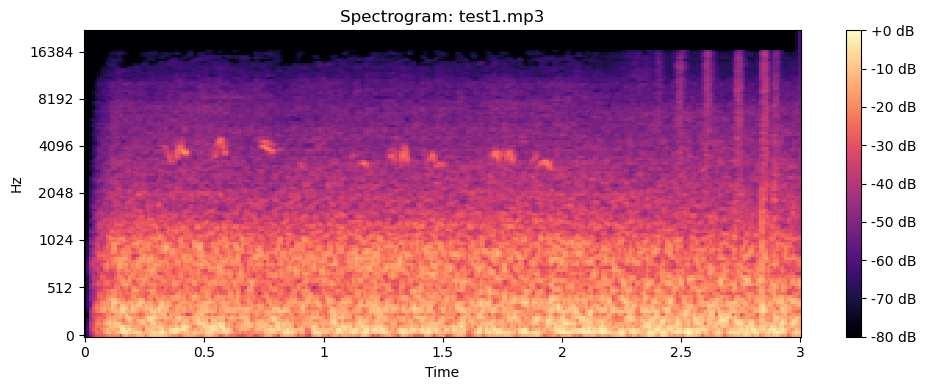

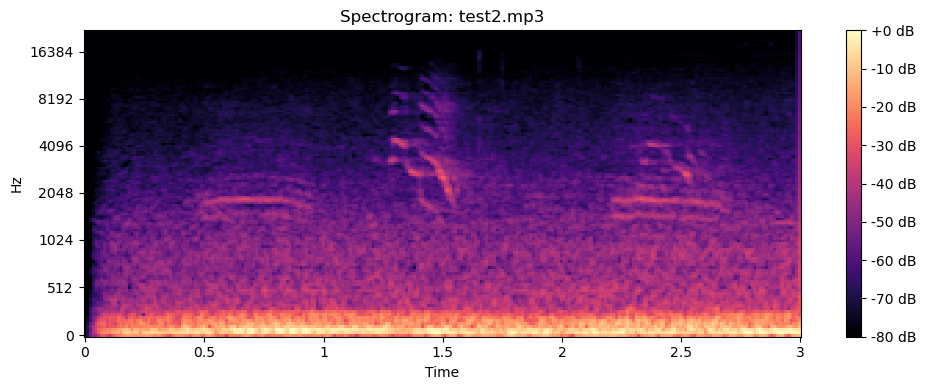

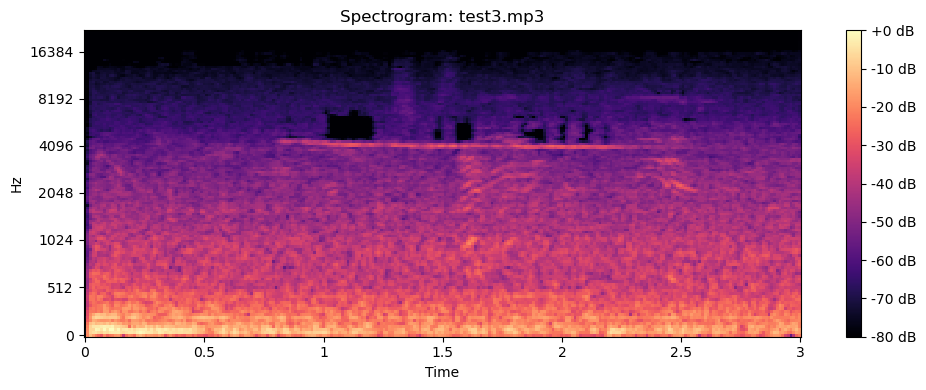

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# List of mp3 file names
files = ['test1.mp3', 'test2.mp3', 'test3.mp3']

def display_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None, duration=3.0)  
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram: {file_path}')
    plt.tight_layout()
    plt.show()

for file in files:
    display_spectrogram(file)


 Processing: test1.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
 Top Predictions:
House Sparrow (houspa): 0.4788
American Crow (amecro): 0.1401
American Robin (amerob): 0.0843
Northern Flicker (norfli): 0.0821
House Finch (houfin): 0.0598
Black-capped Chickadee (bkcchi): 0.0362
Dark-eyed Junco (daejun): 0.0342
Song Sparrow (sonspa): 0.0292
Bewick’s Wren (bewwre): 0.0282
Red-winged Blackbird (rewbla): 0.0123
Spotted Towhee (spotow): 0.0093
White-crowned Sparrow (whcspa): 0.0056


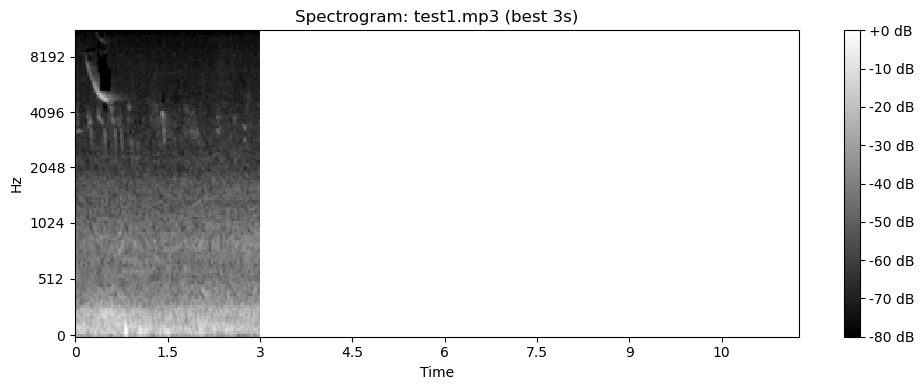

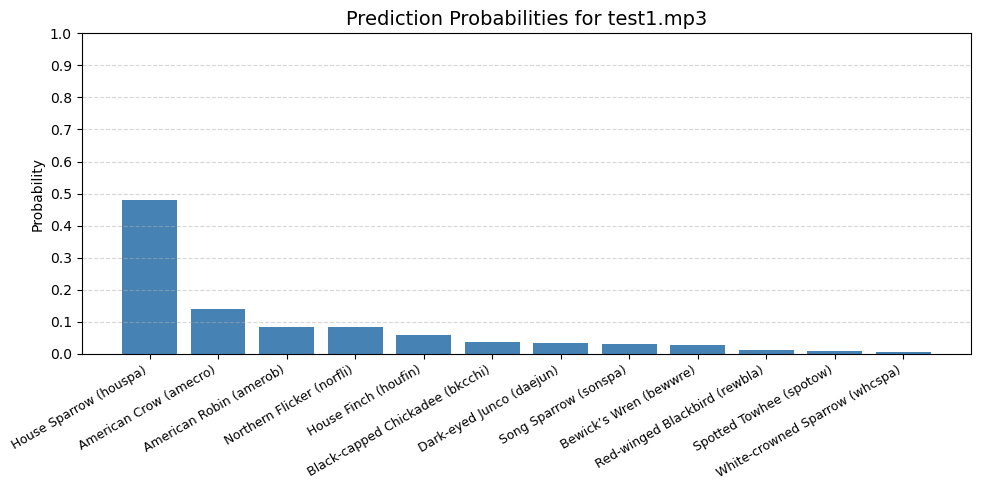


 Processing: test2.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 Top Predictions:
Black-capped Chickadee (bkcchi): 0.6097
Dark-eyed Junco (daejun): 0.0588
American Robin (amerob): 0.0553
Spotted Towhee (spotow): 0.0464
Red-winged Blackbird (rewbla): 0.0460
Bewick’s Wren (bewwre): 0.0422
Song Sparrow (sonspa): 0.0402
White-crowned Sparrow (whcspa): 0.0392
American Crow (amecro): 0.0275
Northern Flicker (norfli): 0.0191
House Sparrow (houspa): 0.0119
House Finch (houfin): 0.0037


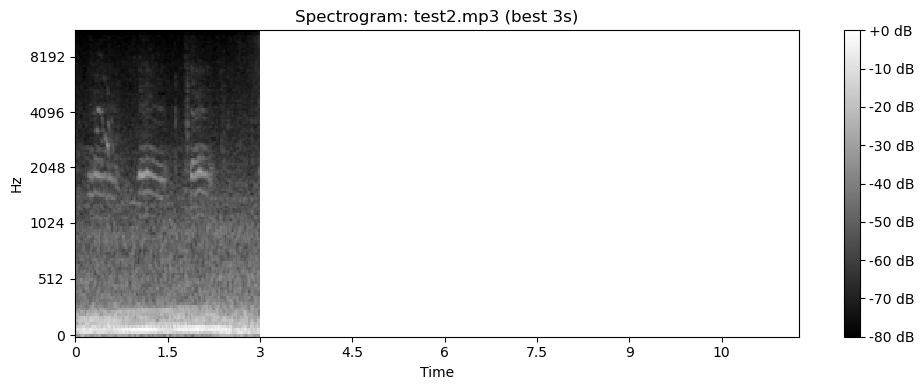

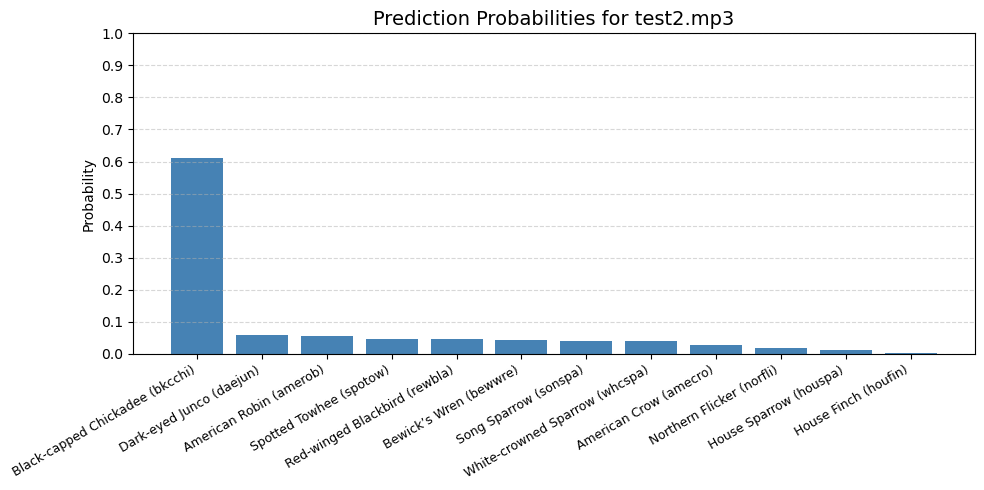


 Processing: test3.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
 Top Predictions:
Black-capped Chickadee (bkcchi): 0.4766
Song Sparrow (sonspa): 0.1361
White-crowned Sparrow (whcspa): 0.1015
American Robin (amerob): 0.0984
Red-winged Blackbird (rewbla): 0.0416
Spotted Towhee (spotow): 0.0398
Dark-eyed Junco (daejun): 0.0332
American Crow (amecro): 0.0249
Bewick’s Wren (bewwre): 0.0225
House Finch (houfin): 0.0151
Northern Flicker (norfli): 0.0083
House Sparrow (houspa): 0.0020


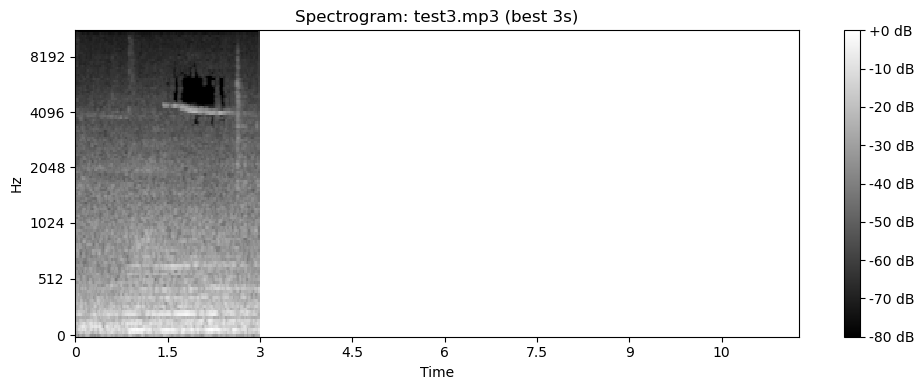

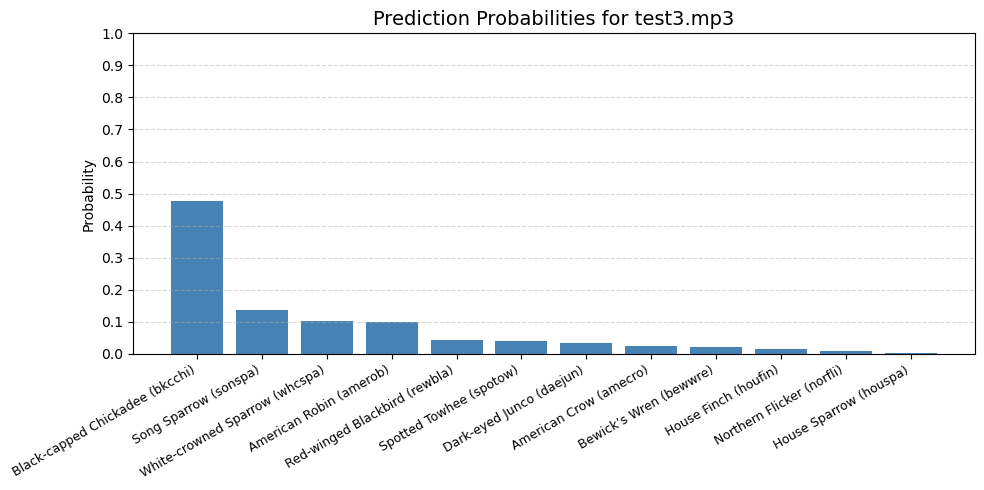

In [57]:
import numpy as np
np.complex = complex  

import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

files = ['test1.mp3', 'test2.mp3', 'test3.mp3']
classes = [
    'American Crow (amecro)', 'American Robin (amerob)', 'Bewick’s Wren (bewwre)', 'Black-capped Chickadee (bkcchi)',
    'Dark-eyed Junco (daejun)', 'House Finch (houfin)', 'House Sparrow (houspa)', 'Northern Flicker (norfli)',
    'Red-winged Blackbird (rewbla)', 'Song Sparrow (sonspa)', 'Spotted Towhee (spotow)', 'White-crowned Sparrow (whcspa)'
]
segment_duration = 3.0
sr_target = 22500

model = load_model("multiclass_bird_cnn_model_final.keras")

def find_best_segment(y, sr, segment_duration=3.0):
    max_energy = 0
    best_start = 0
    samples_per_segment = int(segment_duration * sr)

    for start in np.arange(0, len(y) / sr - segment_duration, 1.0):
        start_sample = int(start * sr)
        segment = y[start_sample:start_sample + samples_per_segment]

        if len(segment) < samples_per_segment:
            continue

        energy = np.sum(segment**2)
        if energy > max_energy:
            max_energy = energy
            best_start = start

    return int(best_start * sr), samples_per_segment

def preprocess_segment(segment, sr):
    S = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    if S_dB.shape[1] < 517:
        pad_width = 517 - S_dB.shape[1]
        S_dB = np.pad(S_dB, ((0, 0), (0, pad_width)), mode='constant')
    else:
        S_dB = S_dB[:, :517]

    S_input = S_dB.astype('float32') / 255.0
    S_input = S_input[np.newaxis, ..., np.newaxis] 
    return S_input, S_dB

def predict_from_best_segment(file_path):
    print(f"\n Processing: {file_path}")
    y, sr = librosa.load(file_path, sr=sr_target)
    start_sample, num_samples = find_best_segment(y, sr)
    segment = y[start_sample:start_sample + num_samples]

    X_input, S_dB = preprocess_segment(segment, sr)
    preds = model.predict(X_input)[0]

    sorted_pairs = sorted(zip(classes, preds), key=lambda x: x[1], reverse=True)
    sorted_classes, sorted_probs = zip(*sorted_pairs)

    # Print results
    print(" Top Predictions:")
    for cls, p in zip(sorted_classes, sorted_probs):
        print(f"{cls}: {p:.4f}")

    # Plot Spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='gray')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram: {file_path} (best 3s)')
    plt.tight_layout()
    plt.show()

    # Plot Probabilities
    import matplotlib.ticker as ticker

    plt.figure(figsize=(10, 5))
    plt.bar(sorted_classes, sorted_probs, color='steelblue')
    
    plt.title(f"Prediction Probabilities for {os.path.basename(file_path)}", fontsize=14)
    plt.ylabel("Probability")
    plt.ylim([0, 1])
    plt.xticks(rotation=30, ha='right', fontsize=9)
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

for file in files:
    predict_from_best_segment(file)